# Explore the Station Precipitation Data

We collected the hourly precipitation (rain gauge) data from 45 CWB stations over the Taipei Basin during 2013/01/01 ~ 2016/12/31.

In this notebook , we try to explore this dataset. In the first part, we will:

  1. Read in all stations precipitation data and make simple visualization.
  2. Convert the raw data into time-by-station tables.
  
And in the second part, we will:

  - Apply filters to find rainfall patterns.
  - Make simple clustering of precipitation time-series.

Prerequisite:

- Python 3.5 and above
- Packages: `numpy`, `pandas`, `matplotlib`, `Basemap`


In [1]:
# Load library
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up parameters for Basemap
lat0 = 21.8875
lat1 = 25.3125
lon0 = 120.0
lon1 = 122.0125

lats = np.arange(21.8875, 25.3125, 0.0125)
lons = np.arange(120.0, 122.0125, 0.0125)

## Part 1: Re-organize the Precipitation Data

We use the functions bellow to read in the precipitation of all 45 stations and re-organize them into tables of time-stations. The processed data is already stored in the `data/`, and hence there is no need to re-run the following sections.

In [ ]:
def read_station_precip(srcdir):
    # List all files to read in the given directory
    import glob,re
    files = glob.glob(srcdir + os.path.sep + '*.csv')
    # Loop through all files
    output = {}
    for f in files:
        # Retrieve station id from the file name
        sta_id = f.replace(srcdir,'').replace('.csv', '')
        tmp = pd.read_csv(f)            # read in data
        time_spans = tmp.keys()[1:]      # get all variables
        # Merge data
        if len(output)==0:
            for t in time_spans:
                output[t] = tmp.loc[:,['date',t]]
                output[t].rename(columns={t: sta_id})
                output[t].columns = ['date', sta_id]
        else:
            for t in time_spans:
                d2 = tmp.loc[:,['date',t]]
                d2.columns = ['date', sta_id]
                output[t] = pd.merge(output[t], d2, on='date')
    return(output)

In [ ]:
tmp = read_station_precip('../precipitation.tpe/')
for k in tmp.keys():
    print(k)
    tmp[k].to_csv(k+'.csv', index=False)

## Part 2: A Quick Look at the Hovemuller Diagram

The stations were not ordered in any sense, so just take a quick look.

(35064, 45)


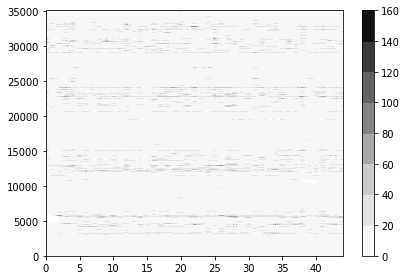

In [7]:
# Read data
tmp = pd.read_csv('./data/t1hr.csv')
#print(tmp.head())
# Move date to index
dates = tmp['date']
t1hr = tmp.iloc[:,1:]
print(t1hr.shape)
# Show Hovemuller Diagram
plt.contourf(t1hr, cmap='Greys')
plt.colorbar()
plt.tight_layout()
plt.show()

The data starts from 2013-01-01 01:00 to 2016-12-31-24:00. The precipitation showed 4 bands which represent the annual cycle. The horizontal lines are mostly solid which means the time-sync between stations is in good shape. However, we want to further check the temporal sync between stations through correlation matrix.

## Correlation Matrix


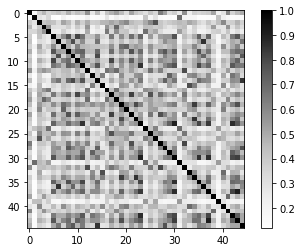

In [8]:
# See the correlation between stations
corm = t1hr.corr()
plt.imshow(corm, cmap='Greys')
plt.colorbar()
plt.show()

The correlation matrix shows that the stations can be re-arranged in a better way.  We use the correlation coefficients with 466920 (Taipei station) to re-arrange the data.

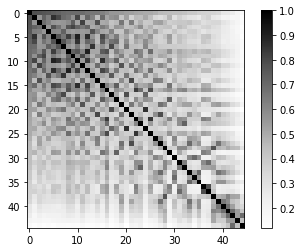

In [9]:
ix = corm.sort_values('466920', ascending=False).index
t1hr_tpe = t1hr.loc[:, ix]
plt.imshow(t1hr_tpe.corr(), cmap='Greys')
plt.colorbar()
plt.show()

The results show no significant groups (darker squares along the diagnal). Let's try clustering method to group stations together.

## Clustering on Precipitation Time Series

The `scikit-learn` package provides a collection of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html), here we try [affinity propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation) for this algorithms provide examplars of each cluster in default output. We simply use the correlation coefficients as the affinity matrix.

In [10]:
# Affinity propagation
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation(preference=0.1,affinity='precomputed').fit(corm)
# See some results
print(clustering)
print(clustering.labels_)
print(clustering.cluster_centers_indices_)
# Create a cluster dictionary
cid = pd.DataFrame(data={'cluster':clustering.labels_}, index=t1hr.keys())
# Examplars
eid = pd.DataFrame(data={'cluster':np.arange(len(clustering.cluster_centers_indices_))}, index=t1hr.keys()[clustering.cluster_centers_indices_])
eid

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=0.1, verbose=False)
[2 4 1 2 2 3 0 5 0 0 1 3 2 5 0 5 2 1 2 5 5 1 5 3 4 1 4 1 0 3 3 4 1 5 5 3 0
 3 2 4 5 2 3 3 0]
[14 17 18 23 31 34]


,cluster
466880,0
C0A9G0,1
C0A530,2
C0AD30,3
C0A880,4
466910,5


Now, we can re-plot the correlation matrix ordered by clusters.

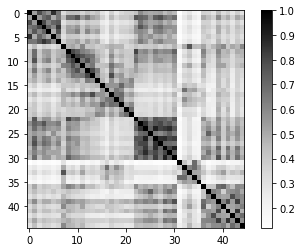

In [11]:
ncluster = len(clustering.cluster_centers_indices_)
new_ord = []
for i in range(ncluster):
    cidx = np.where(clustering.labels_ == i)
    new_ord = new_ord + (list(t1hr.keys()[cidx]))
t1hr_tpe = t1hr.loc[:, new_ord]
plt.imshow(t1hr_tpe.corr(), cmap='Greys')
plt.colorbar()
plt.show()

Now we can see 6 squares in the correlation matrix. And then, what if we plot the Hovemuller diagram with the stations re-ordered by their clusters?

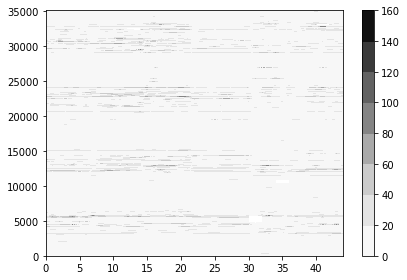

In [14]:
plt.contourf(t1hr_tpe, cmap='Greys')
plt.colorbar()
plt.tight_layout()
plt.show()

The horizontal lines are now more organized(?).


## Adding Station Information

Let's show the clusters on the map. The file `stationlist.txt` contains all CWB stations with their elevation, longitude, and latitude. We read in this file and merge with the cluster-labels.

In [15]:
sta_info = pd.read_csv('data/stationlist.txt')
sta = pd.merge(cid, sta_info, how='left', left_index=True, right_on='STN#')
sta.head()

,cluster,STN#,Elevation,Lon,Lat,Unnamed: 4
38,2,C0A580,70.0,121.5463,24.9224,NaN
50,4,C0A970,96.0,122.0021,25.0076,NaN
6,1,466940,26.7,121.7405,25.1333,NaN
34,2,C0A540,401.0,121.7459,24.8928,NaN
35,2,C0A550,460.0,121.8237,24.9712,NaN


And then, we draw these stations on the map alonmg with their cluster lables.

/Users/tsyo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


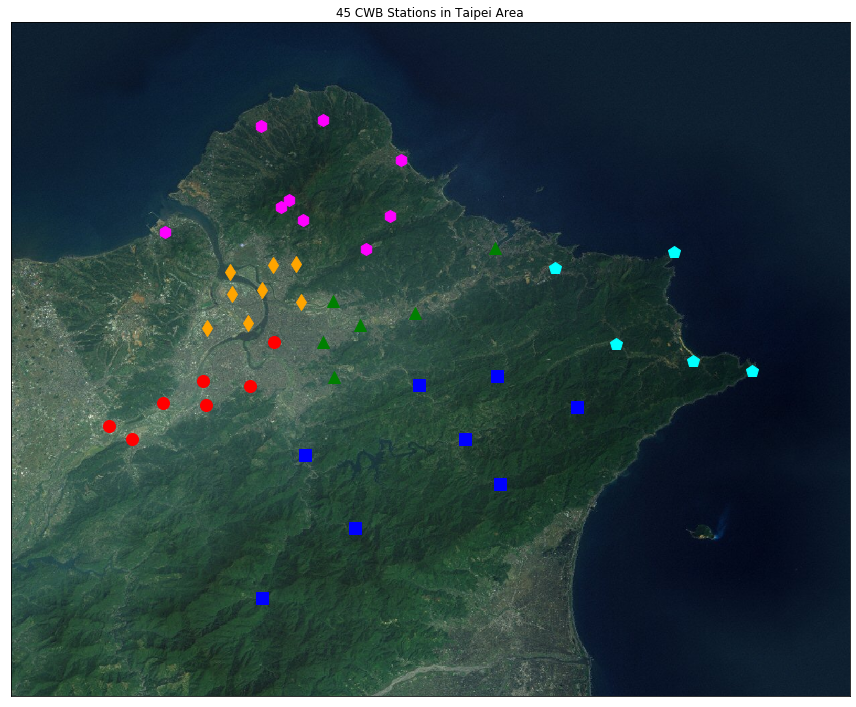

In [28]:
from mpl_toolkits.basemap import Basemap

lat0 = sta['Lat'].min() - 0.1
lat1 = sta['Lat'].max() + 0.1
lon0 = sta['Lon'].min() - 0.1
lon1 = sta['Lon'].max() + 0.1

plt.figure(figsize=(12,12))
m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1)#, resolution='l', epsg=3826)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1600, verbose= False)

nrow, ncol = sta.shape
ctable = ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'yellow']
mtable = ['o', '^', 's', 'd', 'p', 'h', 'x']

for i in range(nrow):
    rec = sta.iloc[i,:]
    m.plot(rec['Lon'], rec['Lat'], color=ctable[rec['cluster']], marker=mtable[rec['cluster']], markersize=12)

plt.title('45 CWB Stations in Taipei Area')
plt.tight_layout()
plt.show()


As shown in the figure above, the clusters are roughly aligned with the topography.

## Distribution of Amount of Precipitation

### Histogrm of Mean Precipitation
Next, we want to see the strength distribution of the precipitation. First we calculate the mean of 45 stations.

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[34950    93    17     4     0     0     0     0     0     0]
[9.96748802e-01 2.65229295e-03 4.84827744e-04 1.14077116e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


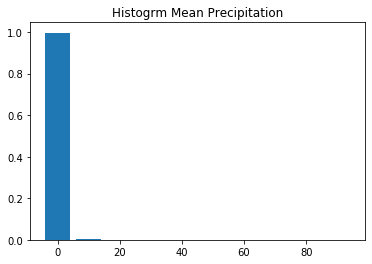

In [29]:
t1hr_mean = t1hr.mean(axis=1)
# Calculate histogram
hist, be = np.histogram(t1hr_mean, bins=10, range=(0,100))
density = (hist/sum(hist))
# Show histogram
print(be)
print(hist)
print(density)
plt.bar(be[:-1], density, width=8)
plt.title('Histogrm Mean Precipitation')
plt.show()

### Histogrm of Max Precipitation

Next, we want to see the strength distribution of the precipitation. First we calculate the maximum of 45 stations.

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[32870  1316   431   208   105    73    31    15     8     6]
[9.37455437e-01 3.75324416e-02 1.22921598e-02 5.93217922e-03
 2.99460970e-03 2.08196675e-03 8.84122865e-04 4.27801386e-04
 2.28160739e-04 1.71120554e-04]


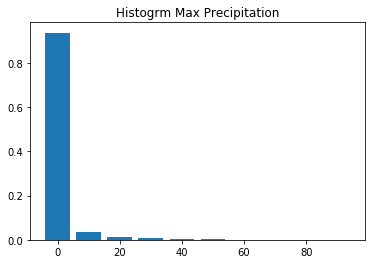

In [30]:
t1hr_max = t1hr.max(axis=1)
# Calculate histogram
hist, be = np.histogram(t1hr_max, bins=10, range=(0,100))
density = (hist/sum(hist))
# Show histogram
print(be)
print(hist)
print(density)
plt.bar(be[:-1], density, width=8)
plt.title('Histogrm Max Precipitation')
plt.show()

## Temporal Features of Precipitation

### Mean Precipitation
Next, we want to show the time series of the precipitation. First we calculate the mean of 45 stations.

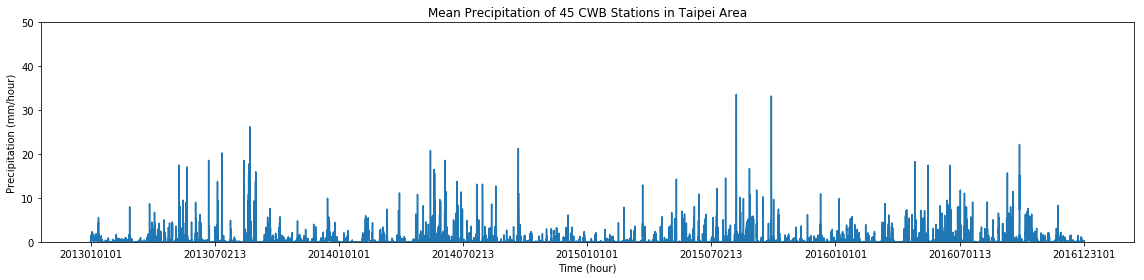

In [26]:
# Mean of stations
t1hr_mean = t1hr.mean(axis=1)
plt.figure(figsize=(16,4))
plt.plot(t1hr_mean)
plt.xticks(np.arange(0, len(t1hr_mean), 4380), list(dates[np.arange(0, len(t1hr_mean), 4380)]))
plt.ylim(0,50)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.title('Mean Precipitation of 45 CWB Stations in Taipei Area')
plt.tight_layout()
plt.show()

### Maximum Precipitation

Since each station has its own geographical characteristics, the 'average' approach will undermine heavy rainfall cases. To select special events, we can use 'maximum' instead of average.

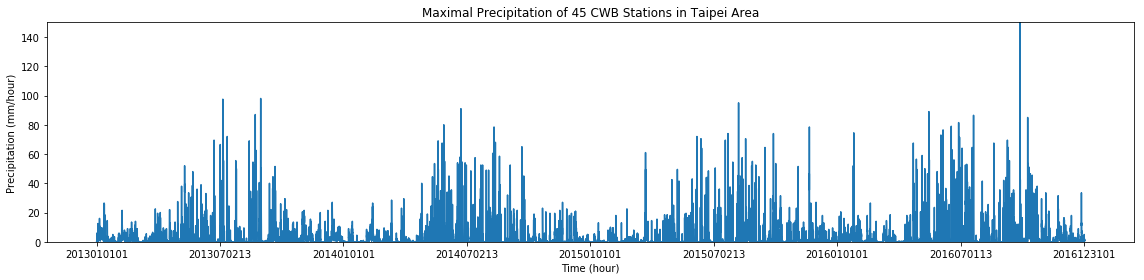

In [27]:
# Max of stations
t1hr_max = t1hr.max(axis=1)
plt.figure(figsize=(16,4))
plt.plot(t1hr_max)
plt.xticks(np.arange(0, len(t1hr_max), 4380), list(dates[np.arange(0, len(t1hr_max), 4380)]))
plt.ylim(0,150)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.title('Maximal Precipitation of 45 CWB Stations in Taipei Area')
plt.tight_layout()
plt.show()

### Precipitation of Cluster Examplars

Also, we can look at the examplars of each cluster to see their differences.

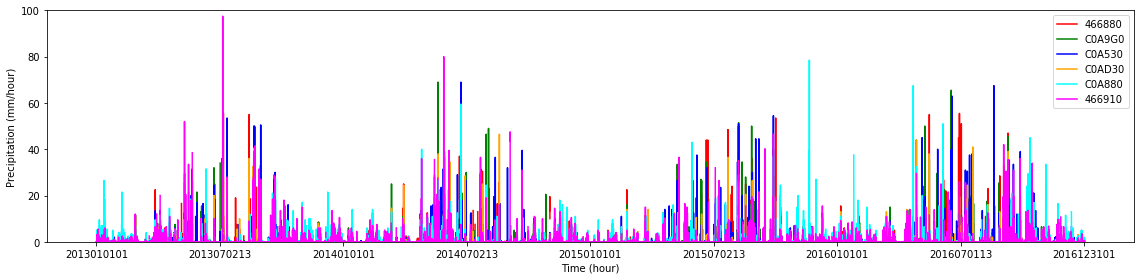

In [15]:
# Time series by cluster
nc = len(clustering.cluster_centers_indices_)
plt.figure(figsize=(16,4))

for i in range(nc):
    ts = t1hr_tpe[eid.index[i]]
    plt.plot(ts, color=ctable[i], label=eid.index[i])

plt.xticks(np.arange(0, len(t1hr_mean), 4380), list(dates[np.arange(0, len(t1hr_mean), 4380)]))
plt.ylim(0,100)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.legend()
plt.tight_layout()
plt.show()

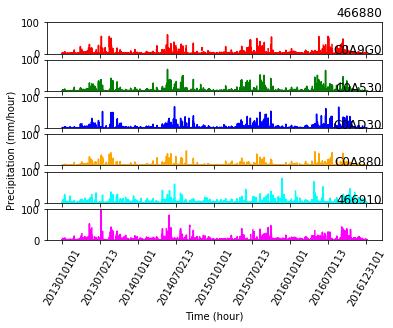

<Figure size 1152x288 with 0 Axes>

In [18]:
# Time series by cluster
nc = len(clustering.cluster_centers_indices_)
fig, ax = plt.subplots(nc,1, sharex=True)
plt.figure(figsize=(16,4))

for i in range(nc):
    ts = t1hr_tpe[eid.index[i]]
    ax[i].plot(ts, color=ctable[i], label=eid.index[i])
    ax[i].set_title(eid.index[i], loc='right')
    ax[i].set_ylim(0,100)
    ax[i].set_xticks(np.arange(0, len(ts), 4380))
    ax[i].set_xticklabels(list(dates[np.arange(0, len(ts), 4380)]), rotation=60)

ax[5].set_xlabel('Time (hour)')
ax[3].set_ylabel('Precipitation (mm/hour)')
plt.tight_layout()
plt.show()

## Typhoon Cases During 2013~2016

Next, we will look into the Typhoon warnings during 2013~2016.

In [20]:
# Read in Typhoon warning data
tyw = pd.read_excel('2013-2016_TYW.xlsx')

# Align the Typhoon warning time stamp with the precipitation
t1=[]
t2=[]
for i in range(tyw.shape[0]):
    ty = tyw.iloc[i,:]
    d1 = ty['start_date'].strftime('%Y%m%d')+'01'
    d2 = ty['end_date'].strftime('%Y%m%d')+'01'
    t1.append(list(dates).index(int(d1)))
    t2.append(list(dates).index(int(d2)))

tyw['start_idx'] = t1
tyw['end_idx'] = t2

tyw

,start_date,end_date,name_zhtw,name,start_idx,end_idx
0,2013-07-11,2013-07-13,蘇力,SOULIK,4584,4632
1,2013-07-17,2013-07-18,西馬隆,CIMARON,4728,4752
2,2013-08-20,2013-08-22,潭美,TRAMI,5544,5592
3,2013-08-27,2013-08-29,康芮,KONG-REY,5712,5760
4,2013-09-19,2013-09-22,天兔,USAGI,6264,6336
5,2013-10-04,2013-10-07,菲特,FITOW,6624,6696
6,2014-06-14,2014-06-15,哈吉貝,HAGIBIS,12696,12720
7,2014-07-21,2014-07-23,麥德姆,MATMO,13584,13632
8,2014-09-19,2014-09-22,鳳凰,FUNG-WONG,15024,15096
9,2015-05-10,2015-05-11,紅霞,NOUL,20616,20640


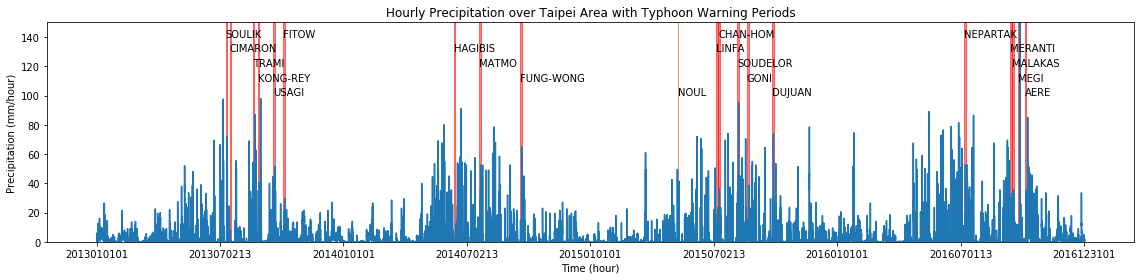

In [21]:
# Plot the maximal precipitation
plt.figure(figsize=(16,4))
plt.plot(t1hr_max)
# Label Typhoon warnings
labposys = [140, 130, 120, 110, 100]
for i in range(tyw.shape[0]):
    ty = tyw.iloc[i,:]
    plt.axvspan(ty['start_idx'], ty['end_idx'], alpha=0.5, color='red')
    plt.text(ty['start_idx'], labposys[i%5], ty['name'])
    
plt.xticks(np.arange(0, len(t1hr_max), 4380), list(dates[np.arange(0, len(t1hr_max), 4380)]))
plt.ylim(0,150)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.title('Hourly Precipitation over Taipei Area with Typhoon Warning Periods')
plt.tight_layout()
plt.show()

### Heavy Rain by Definition

Apparently, many heavy rainfall events didn't happen within Typhoon warning periods. Let us check out all events with different thresholds.

According to [CWB](https://www.cwb.gov.tw/V7/observe/rainfall/define.htm):
- **heavy rain**: 40 mm/hr or 80mm/day
- **extremely heavy rain**: 100mm/3hr or 200/day
- **torrential rain**: 350mm/day
- **extremely torrential rain**: 500mm/day



In [22]:
# Scan for rain events
# heavy rainfall by hourly rain (>40mm/hr)
hr1 = []
for i in range(len(t1hr_max)):
    if t1hr_max[i] >= 40.:
        hr1.append(i)

# extremely heavy rainfall by 3-hour rain (>100mm/hr)
t3hr_max = pd.read_csv('t3hr.csv').iloc[:,1:].max(axis=1)
ehr1 = []
for i in range(len(t3hr_max)):
    if t3hr_max[i] >= 100.:
        ehr1.append(i)

# All events by daily        
t24hr_max = pd.read_csv('t24hr.csv').iloc[:,1:].max(axis=1)
hr2 = []
ehr2 = []
tr = []
etr = []
for i in range(len(t24hr_max)):
    if t24hr_max[i] >= 80.:
        hr2.append(i)
    if t24hr_max[i] >= 100.:
        ehr2.append(i)
    if t24hr_max[i] >= 350.:
        tr.append(i)
    if t24hr_max[i] >= 500.:
        etr.append(i)


In [23]:
# Process the index list to keep only the start and end index
def indexlist_to_table(idxlist):
    i1 = []
    i2 = []
    i1.append(idxlist[0])
    i = 1
    tmp = idxlist[0]
    while i<(len(idxlist)-1):
        # If current index is the last in a series, add it to end-index i2
        if not (idxlist[i]+1 in idxlist):
            i2.append(idxlist[i])
            i1.append(idxlist[i+1])
        # Move on
        i += 1
    # End loop
    i2.append(idxlist[-1])
    return(pd.DataFrame({'start_idx':i1, 'end_idx':i2}))

hr2idx = indexlist_to_table(hr2)
hr2idx.head()

,start_idx,end_idx
0,32,74
1,79,105
2,131,134
3,148,207
4,243,286


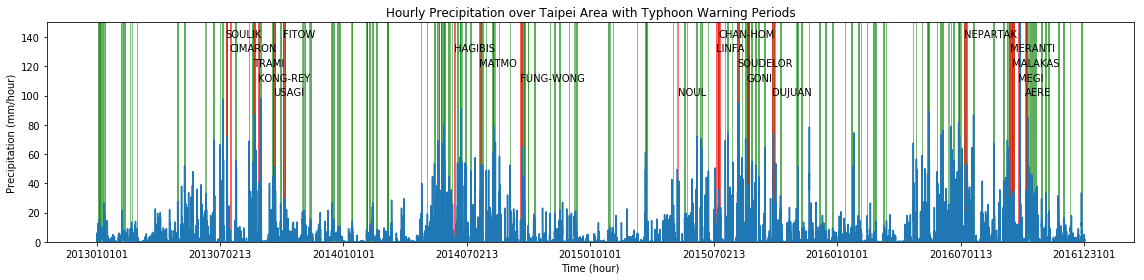

In [25]:
# Plot the maximal precipitation
plt.figure(figsize=(16,4))
plt.plot(t1hr_max)
# Label HR2 (the lowest threshold)
for i in range(hr2idx.shape[0]):
    tmp = hr2idx.iloc[i,:]
    plt.axvspan(tmp['start_idx'], tmp['end_idx'], alpha=0.5, color='green')
# Label Typhoon warnings
labposys = [140, 130, 120, 110, 100]
for i in range(tyw.shape[0]):
    ty = tyw.iloc[i,:]
    plt.axvspan(ty['start_idx'], ty['end_idx'], alpha=0.5, color='red')
    plt.text(ty['start_idx'], labposys[i%5], ty['name'])
    
plt.xticks(np.arange(0, len(t1hr_max), 4380), list(dates[np.arange(0, len(t1hr_max), 4380)]))
plt.ylim(0,150)
plt.xlabel('Time (hour)')
plt.ylabel('Precipitation (mm/hour)')
plt.title('Hourly Precipitation over Taipei Area with Typhoon Warning Periods')
plt.tight_layout()
plt.show()

In [21]:
# Write out event index
pd.DataFrame(dates[hr1]).to_csv('hr1.csv')
pd.DataFrame(dates[hr2]).to_csv('hr2.csv')
pd.DataFrame(dates[ehr1]).to_csv('ehr1.csv')
pd.DataFrame(dates[ehr2]).to_csv('ehr2.csv')
pd.DataFrame(dates[tr]).to_csv('tr.csv')
pd.DataFrame(dates[etr]).to_csv('etr.csv')